In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fuzzywuzzy import fuzz
from tqdm import tqdm

sns.set_style("whitegrid")

In [2]:
#Load the data
import pickle
#with open("../data/deduped_policy_text_v11no_html_with_links_and_emails.pickle", "rb") as f:
with open("../data/policy_text_v11.pickle", "rb") as f:
    df = pickle.load(f)

In [3]:
#Get all intervals
def get_intervals(df):
    intervals = set(((y,s) for y,s in zip(df.year,df.season)))
    intervals = sorted(list(intervals)) #This will correctly sort due to Python's tuple handling behavior
    return intervals
    

In [4]:
#General plot things

intervals = get_intervals(df)
x = list(range(len(intervals)))
labels = ["%d%s" % interval for interval in intervals]

In [5]:
def present_for_desired_intervals(df,site_url,intervals):
    hits = 0
    for i,row in df[df.site_url == site_url].iterrows():
        if (row.year,row.season) in intervals:
            hits += 1
    return hits == len(intervals)

site_urls = list(set(df.site_url))

persist_intervals = list(filter(lambda interval: interval[0] >= 2010, intervals))
persistent_site_urls = set((site_url for site_url,site_df in df.groupby("site_url") if present_for_desired_intervals(site_df,site_url,persist_intervals)))

In [6]:
persistent_site_urls = set(persistent_site_urls)

def filter_persistent_sites(row):
    if row.site_url in persistent_site_urls and (row.year,row.season) in persist_intervals:
        return True
    return False

    
df_persistent = df[df.apply(filter_persistent_sites,axis=1)]

In [7]:
top1kdoms = set(df[df.alexa_rank <= 1000].site_url)
df_1k = df[df.site_url.isin(top1kdoms)]

In [8]:
len(set(df_persistent.site_url))

1594

In [9]:
pd.DataFrame({"A":[True,False,None]}).A.mean()

0.5

In [10]:
update_ratio = df.groupby('year_season').simhash_updated.mean()
update_df = update_ratio.to_frame()
update_df["strict_updated"] = df.groupby('year_season').strict_updated.mean()
update_df["interval"] = pd.Series(list(update_ratio.index),index=update_ratio.index)

In [11]:
def set_x_ticks(df):
    unique_intervals = df['interval'].unique()
    num_intervals = len(unique_intervals)
    unique_years = sorted(set([int(interval.split("_")[0]) for interval in unique_intervals]))
    plt.xticks(np.arange(0, num_intervals, 2) + 0.5, unique_years, rotation="vertical")

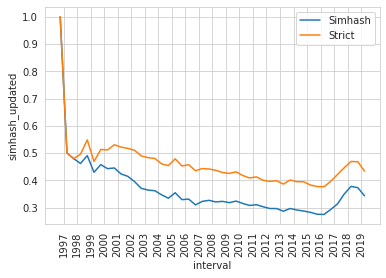

In [12]:
sns.lineplot(x="interval",y="simhash_updated",data=update_df,label="Simhash")
sns.lineplot(x="interval",y="strict_updated",data=update_df,label="Strict")
set_x_ticks(update_df)
plt.legend()

In [ ]:
from tqdm import tqdm
import simhash
SIMHASH_THRESHOLD = 3

def mark_updated_policies(df):
    strict_updated = set()
    simhash_updated = set()
    null_update = set()

    last_sha1s = {}
    last_simhashes =  {}
    

    for index, row in tqdm(df.iterrows()):
        site_url = row['site_url']
        curr_simhash = row['simhash']
        curr_sha1 = row['sha1']
        year = row['year']
        season = row['season']
        homepage_snapshot_url = row['homepage_snapshot_url']

        t = last_sha1s.get(site_url)
        if t is not None:
            last_sha1, l_year, l_season = t
            
            if last_sha1 != curr_sha1:
                strict_updated.add(homepage_snapshot_url)

            last_simhash, l_year, l_season = last_simhashes.get(site_url)
            if simhash.num_differing_bits(last_simhash, curr_simhash) > SIMHASH_THRESHOLD:
                simhash_updated.add(homepage_snapshot_url)
        last_simhashes[site_url] = (curr_simhash, year, season)
        last_sha1s[site_url] = (curr_sha1, year, season)
        
        if t is not None and ((season == 'A' and (year - 1 == l_year and l_season == 'B')) or (season == 'B' and (year == l_year and l_season == 'B'))):
            pass
        else:
            null_update.add(homepage_snapshot_url)

    def in_or_null_strict(homepage_snapshot_url):
        if homepage_snapshot_url in null_update:
            return None
        else:
            return homepage_snapshot_url in strict_updated
            
    
    def in_or_null_simhash(homepage_snapshot_url):
        if homepage_snapshot_url in null_update:
            return None
        else:
            return homepage_snapshot_url in simhash_updated
            
    df['strict_updated'] = df.homepage_snapshot_url.map(in_or_null_strict)
    df['simhash_updated'] = df.homepage_snapshot_url.map(in_or_null_simhash)
    return df

In [ ]:
def mark_updated_policies(df):
    strict_updated = set()
    simhash_updated = set()

    last_sha1s = {}
    last_simhashes =  {}

    for index, row in tqdm(df.iterrows()):
        site_url = row['site_url']
        curr_simhash = row['simhash']
        curr_sha1 = row['sha1']
        homepage_snapshot_url = row['homepage_snapshot_url']

        last_sha1 = last_sha1s.get(site_url)
        if last_sha1 is not None and last_sha1 != curr_sha1:
            strict_updated.add(homepage_snapshot_url)
        last_sha1s[site_url] = curr_sha1

        last_simhash = last_simhashes.get(site_url)
        if last_simhash is not None and simhash.num_differing_bits(last_simhash, curr_simhash) > SIMHASH_THRESHOLD:
            simhash_updated.add(homepage_snapshot_url)
        last_simhashes[site_url] = curr_simhash

    df['strict_updated'] = df.homepage_snapshot_url.isin(strict_updated)
    df['simhash_updated'] = df.homepage_snapshot_url.isin(simhash_updated)

In [62]:
def mark_updated_policies(df):
    
    last_policy = {}
    update_ratio = pd.Series(100,index=df.index,name="update_ratio")
    for index, row in tqdm(df.sort_values("year_season").iterrows(),total=len(df)):
        if row.site_url in last_policy:
            update_ratio.loc[index] = fuzz.ratio(row.policy_text,last_policy[row.site_url])
        last_policy[row.site_url] = row.policy_text
    df['update_ratio'] = update_ratio
    return df

In [ ]:
def default_mean(s):
    try:
        return s.mean()
    except:
        return 0

In [40]:
#Load the data
import pickle
with open("../data/deduped_policy_text_v11no_html_with_links_and_emails.pickle", "rb") as f:
#with open("../data/deduped_policy_text_v11.pickle", "rb") as f:
    df_deduped_full = pickle.load(f)
    df_deduped = df_deduped_full.sample(10000)

In [73]:
df_deduped = df_deduped_full

In [74]:
list(df_deduped)

['site_url',
 'year',
 'season',
 'policy_text',
 'policy_snapshot_url',
 'policy_filetype',
 'raw_source_path',
 'link_text',
 'homepage_snapshot_url',
 'homepage_snapshot_redirected_url',
 'sha1',
 'flesch_kincaid',
 'smog',
 'flesch_ease',
 'policy_title',
 'text_len',
 'word_count',
 'year_season',
 'simhash',
 'policy_url',
 'home_domain',
 'ip_based_homepage_url',
 'categories',
 'policy_snapshot_domain',
 'strict_updated',
 'simhash_updated',
 'homepage_snapshot_domain',
 'homepage_snapshot_redirected_domain',
 'parked_domain',
 'classifier_probability',
 'alexa_rank',
 'cross_domain_homepage_redir',
 'redirected_to_similar_domain',
 'cross_domain_policy',
 'emails',
 'has_email',
 'links',
 'has_external_link']

In [75]:
df_deduped = mark_updated_policies(df_deduped)

 89%|████████▊ | 807016/910546 [7:04:34<2:15:33, 12.73it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 910546/910546 [10:09:36<00:00, 24.89it/s]   


In [ ]:
update_ratio = df.groupby('year_season').simhash_updated.apply(default_mean)#mean()
update_df = update_ratio.to_frame()
update_df["strict_updated"] = df.groupby('year_season').strict_updated.apply(default_mean)#mean()
update_df["interval"] = pd.Series(list(update_ratio.index),index=update_ratio.index)
update_df["simhash_update_deduped"] = df_deduped.groupby('year_season').simhash_updated.apply(default_mean)#mean()
update_df["strict_updated_deduped"] = df_deduped.groupby('year_season').strict_updated.apply(default_mean)#mean()
update_df["interval"] = pd.Series(list(update_ratio.index),index=update_ratio.index)
sns.lineplot(x="interval",y="simhash_update_deduped",data=update_df,label="Simhash (Deduped)")
sns.lineplot(x="interval",y="strict_updated_deduped",data=update_df,label="Strict (Deduped)")
sns.lineplot(x="interval",y="simhash_updated",data=update_df,label="Simhash")
fig = sns.lineplot(x="interval",y="strict_updated",data=update_df,label="Strict")
#set_x_ticks(update_df)

xlabels = sorted(list(set(update_df.interval)))
xlabels = map(lambda s: s.replace("_",""), xlabels)
#fig.set_xticklabels(fig.get_xticklabels())
fig.set_xticklabels(xlabels, rotation=90, fontsize='small')


plt.legend()

In [ ]:
df[df.year_season == "2009_A"].simhash_updated

In [ ]:
df = df.drop("strict_updated",axis=1).drop("simhash_updated",axis=1)
df = mark_updated_policies(df)

In [ ]:
sns.lineplot(x="interval",y="simhash_updated",data=update_df,label="Simhash")
sns.lineplot(x="interval",y="strict_updated",data=update_df,label="Strict")
set_x_ticks(update_df)
plt.legend()

In [ ]:
update_ratio = df_persistent.groupby('year_season').simhash_updated.apply(default_mean)#mean()
update_df = update_ratio.to_frame()
update_df["strict_updated"] = df_persistent.groupby('year_season').strict_updated.apply(default_mean)#mean()
update_df["interval"] = pd.Series(list(update_ratio.index),index=update_ratio.index)
sns.lineplot(x="interval",y="simhash_updated",data=update_df,label="Simhash")
fig = sns.lineplot(x="interval",y="strict_updated",data=update_df,label="Strict")

set_x_ticks(update_df)

fig.set_ylim(0,1)

plt.legend()

In [ ]:
update_ratio = df_1k.groupby('year_season').simhash_updated.apply(default_mean)#mean()
update_df = update_ratio.to_frame()
update_df["strict_updated"] = df_1k.groupby('year_season').strict_updated.apply(default_mean)#mean()
update_df["interval"] = pd.Series(list(update_ratio.index),index=update_ratio.index)
sns.lineplot(x="interval",y="simhash_updated",data=update_df,label="Simhash")
fig = sns.lineplot(x="interval",y="strict_updated",data=update_df,label="Strict")

set_x_ticks(update_df)

fig.set_ylim(0,1)

plt.legend()

# Fuzzy Updates

In [ ]:
import nltk
import nltk.stem

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
gdpr_phrases = []
with open("data/GDPR_phrases.txt") as f:
    for line in f.readlines():
        gdpr_phrases.append(" ".join(map(lemmatizer.lemmatize,line.split(" "))))

In [33]:
def lemmatize_policy(policy_text):
    return " ".join(map(lemmatizer.lemmatize,nltk.word_tokenize(policy_text)))

SyntaxError: unexpected EOF while parsing (<ipython-input-33-d0d04ea1b62f>, line 1)

In [ ]:
df_deduped["policy_text_lemmatized"] = df_deduped.policy_text.map(lemmatize_policy)

In [ ]:
cols = []
for phrase in gdpr_phrases:
    df_phrase_count = df_deduped.groupby("year_season").policy_text_lemmatized.str.contains(phrase).value_counts().True
    df_phrase_count["phrase"] = phrase
    cols.append(
        df_phrase_count
    )


In [ ]:
sns.lineplot(x="year_season","")

In [78]:
df_deduped = df_deduped.sort_values("year_season")
df_deduped["update_ratio_95"] = df_deduped.update_ratio <= 95

In [68]:
len(df_deduped)

10000

<AxesSubplot:xlabel='year_season', ylabel='count'>

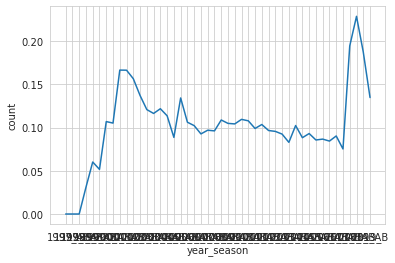

In [82]:
updates_ct = pd.DataFrame(df_deduped.groupby("year_season").apply(lambda df: len(df[df.update_ratio <= 95]) / len(df_deduped[df_deduped.year_season == df.year_season.iloc[0]])).rename("count")).reset_index()
#sns.lineplot()
sns.lineplot(x="year_season",y="count",data=updates_ct)

<AxesSubplot:xlabel='year_season', ylabel='update_ratio_95'>

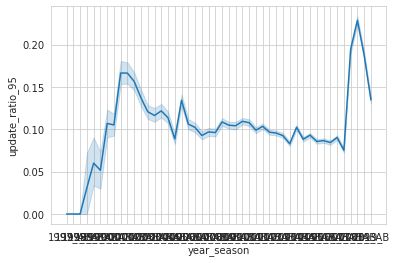

In [80]:
sns.lineplot(x="year_season", y="update_ratio_95",data=df_deduped,)

In [66]:
row = df_deduped.sample(1).iloc[0]
row

site_url                                                               http://ebooks.com
year                                                                                2006
season                                                                                 B
policy_text                            Download a book today  \n52,000 popular, profe...
policy_snapshot_url                    https://web.archive.org/web/20060819083053id_/...
policy_filetype                                                                     html
raw_source_path                        crawl1/data-09/out/policy_html/6866_2006_B_200...
link_text                                                                 Privacy Policy
homepage_snapshot_url                  https://web.archive.org/web/20060929141439id_/...
homepage_snapshot_redirected_url       https://web.archive.org/web/20060929141439id_/...
sha1                                            7eec960afc8d66013592ee129011818e134e04ab
flesch_kincaid       